<a href="https://colab.research.google.com/github/johanjan/MOOC-HPFEM-source/blob/master/MOOC_HPFEM_Fluid_2018_1_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### MOOC-HPFEM: Navier-Stokes fluid flow Direct FEM Simulation (DFS)



<p>Incompressible Navier-Stokes as model for low and high Reynolds number flow, such as blood flow and flight: <span class="math display">\begin{array}{rcll} 
R(\hat{u}) &;=&
\begin{cases}
  p_t u + (u\cdot \nabla) u + \nabla p - \nu \Delta u = 0\\
  \nabla \cdot u = 0
\end{cases}\\
u &;=& 0, x \in \Gamma \quad (\text{No-slip BC for low Reynolds number})\\
\hat{u} &=& (u, p), \quad r(\hat{u}, \hat{v}) = (R(\hat{u}), \hat{v}) \quad (\text{Weak residual})
\end{array}</span></p>
<dl>
<dt>Space-time cG(1)cG(1) FEM with GLS stabilization. Developed over 20+ years by Johnson, Hoffman, Jansson, etc.</dt>
<dd><p><span class="math display">\begin{aligned}
  &r(\hat{U}, \hat{v}) = (R(\hat{U}), \hat{v}) + (\delta R(\hat{U}), R(\hat{v})) = 0\\
  &\delta = h, \, \forall \hat{v} \in \hat{V}_h, \, \hat{U} \in \hat{V}_h\end{aligned}</span></p>
</dd>

### FEniCS DFS formulation to run and modify yourself

In [0]:
#@title
# Setup system environment and define utility functions and variables
from google.colab import files
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !sed -e 's:artful:bionic:' /etc/apt/sources.list.d/fenics-packages-ubuntu-fenics-artful.list > temp
    !mv temp /etc/apt/sources.list.d/fenics-packages-ubuntu-fenics-artful.list
    !sed -e 's:artful:bionic:' /etc/apt/sources.list > temp
    !mv temp /etc/apt/sources.list
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics    
    from dolfin import *; from mshr import *
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display, update_display; import time; import dolfin.common.plotting as fenicsplot 
import time

def plot_compact(u, t, stepcounter, QQ): # Compact plot utility function
    if stepcounter % 5 == 0:
        uEuclidnorm = project(sqrt(inner(u, u)), QQ); ax.cla(); fig = plt.gcf(); fig.set_size_inches(16, 4)
        plt.subplot(1, 2, 1); pp = plot(uEuclidnorm); plt.title("Velocity at t=%f" % (t)) # Plot norm of velocity
        if t == 0.: plt.axis(G); plt.colorbar(pp, shrink=0.5); 
        plt.subplot(1, 2, 2);
        if t == 0.: plot(Q.mesh()); plt.title("Mesh") # Plot mesh
        plt.tight_layout(); dpl = display(pl, display_id="test");

XMIN = 0.; XMAX = 4; YMIN = 0; YMAX = 1.; G = [XMIN, XMAX, YMIN, YMAX]; eps = 1e-5; mresolution=30 # Geometry and mesh
mesh = generate_mesh(Rectangle(Point(G[0], G[2]), Point(G[1], G[3])) - Circle(Point(.5, .5), .1), mresolution)

VE = VectorElement("CG", mesh.ufl_cell(), 1); QE = FiniteElement("CG", mesh.ufl_cell(), 1); h = CellDiameter(mesh); # FEM functions
WE = VE * QE; W = FunctionSpace(mesh, WE); V = FunctionSpace(mesh, VE); Q = FunctionSpace(mesh, QE) # Make a mixed space
(v, q) = TestFunctions(W); w = Function(W); (u, p) = (as_vector((w[0], w[1])), w[2]); u0 = Function(V)

uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V.ufl_element()) # Inflow velocity
om = Expression("x[0] > XMAX - eps ? 1. : 0.", XMAX=XMAX, eps=eps, element = Q.ufl_element()) # Mark regions for boundary conditions
im = Expression("x[0] < XMIN + eps ? 1. : 0.", XMIN=XMIN, eps=eps, element = Q.ufl_element())
nm = Expression("x[0] > XMIN + eps && x[0] < XMAX - eps ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, eps=eps, element = Q.ufl_element())

stepcounter = 0; 

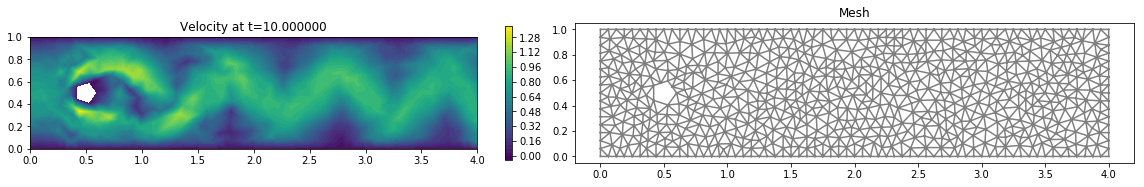

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


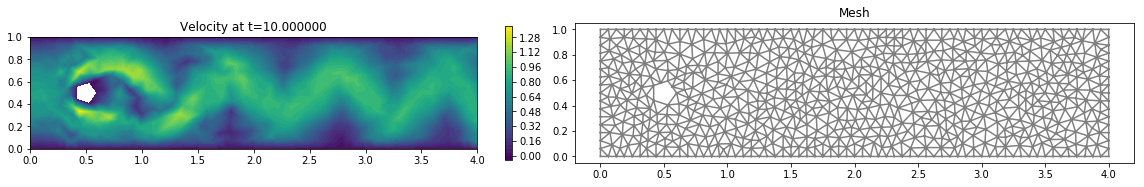

In [4]:
# Copyright (c) 2017-2018 Johan Jansson, Cem Degirmenci, David Kamensky, FEniCS community contributions 
pl, ax = plt.subplots(); display(pl); clear_output(); # Plotting setup

k = 0.1; nu = 1e-6; d = .2*h**(3./2.) # Timestep, viscosity and stabilization parameters
t, T = 0., 10.; gamma = 10*1./h # Time interval and penalty parameter

theta = 0.5 # 0.5 - Midpoint rule, 1.0 - Implicit Euler, 0.0 - Explicit Euler
while t < T: # Time-stepping loop
    um = theta*u + (1.0-theta)*u0 # Weak residual of stabilized FEM for Navier-Stokes eq.
    r = ((inner((u - u0)/k + grad(p) + grad(um)*um, v) + nu*inner(grad(um), grad(v)) + div(um)*q)*dx +
        gamma*(om*p*q + im*inner(u - uin, v) + nm*inner(u, v))*ds + # Weak boundary conditions
        d*(inner(grad(p) + grad(um)*um, grad(q) + grad(um)*v) + inner(div(um), div(v)))*dx) # Stabilization
    solve(r==0, w)  # Solve the Navier-Stokes PDE (one timestep)
    plot_compact(u, t, stepcounter, Q) # Plot all quantities (see implementation above)
    t += k; stepcounter += 1; u0 = project(u, V); # Shift to next timestep